In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import xarray as xr
import numpy as np
from datetime import date, timedelta
import sys
sys.path.append('src')
from src.dataloaders import *
import math
import csv

class MultiHeadDecoder(nn.Module):
    def __init__(self, latent_dim, output_channels, num_heads, output_size, hidden_dim=256):
        super(MultiHeadDecoder, self).__init__()

        self.latent_dim = latent_dim
        self.output_channels = output_channels
        self.num_heads = num_heads
        self.output_size = output_size
        self.hidden_dim = hidden_dim

        # Shared initial layers, directly outputting the right shape for heads
        self.shared_layers = nn.Sequential(
            nn.Linear(latent_dim, num_heads * 4 * 4 * 512),
            nn.ReLU()
        )

        # Calculate starting size and upscaling steps for ConvTranspose2d
        start_size = 16  
        upscale_factor = int(math.log2(output_size / start_size))
        # print(upscale_factor)
        if 2**upscale_factor != output_size / start_size:
            raise ValueError(f"Output size {output_size} must be a power of 2 multiple of the minimum size {start_size}")

        # # Define individual decoder heads
        # self.heads = nn.ModuleList([
        #     nn.Sequential(
        #         nn.ConvTranspose2d(hidden_dim, hidden_dim, 4, stride=2, padding=1, bias=False),
        #         # nn.BatchNorm2d(hidden_dim),
        #         nn.ReLU(),
        #         # Additional ConvTranspose2d layers if needed
        #         *[nn.ConvTranspose2d(hidden_dim, hidden_dim, 4, stride=2, padding=1, bias=False) for _ in range(upscale_factor - 1)],
        #         nn.ConvTranspose2d(hidden_dim, output_channels, 4, stride=2, padding=1, bias=False),  # Last layer for output
        #         # One more layer for the extra factor of 2
        #         nn.ConvTranspose2d(output_channels, output_channels, 4, stride=2, padding=1, bias=False) 
        #     ) for _ in range(num_heads)
        # ])

        # Define individual decoder heads
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                # nn.BatchNorm2d(256),
                nn.ReLU(),

                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                # nn.BatchNorm2d(128),
                nn.ReLU(),

                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                # nn.BatchNorm2d(64),
                nn.ReLU(),

                nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False),
                # nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1, bias=False),
                # nn.BatchNorm2d(1),
            ) for _ in range(num_heads)
        ])


    
    def forward(self, z):
        # Pass through shared layers 
        z = self.shared_layers(z)

        # Reshape for decoder heads 
        z = z.view(-1, self.num_heads, 512, 4, 4)

        # Decode with each head
        outputs = [head(z[:, i, :]) for i, head in enumerate(self.heads)]

        # Concatenate head outputs along the channel dimension
        return torch.cat(outputs, dim=1) 

class MultiHeadEncoder(nn.Module):
    def __init__(self, latent_dim, input_channels, num_heads, input_size, hidden_dim):
        super(MultiHeadEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        self.input_channels = input_channels
        self.num_heads = num_heads
        self.input_size = input_size
        self.hidden_dim = hidden_dim

        # Individual encoder heads
        self.heads = nn.ModuleList([
            nn.Sequential(
                # Initial Conv2d layer, mirroring the decoder's last
                nn.Conv2d(input_channels, 32, 4, stride=2, padding=1, bias=False),
                # nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(32, 64, 4, stride=2, padding=1, bias=False),
                # nn.BatchNorm2d(64),
                nn.ReLU(),

                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                # nn.BatchNorm2d(128),
                nn.ReLU(),

                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                # nn.BatchNorm2d(256),
                nn.ReLU(),

                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                # nn.BatchNorm2d(512),
                nn.ReLU(),
            ) for _ in range(num_heads)
        ])

        # Shared final layers, outputting the latent representation
        self.shared_layers = nn.Sequential(
            # nn.ReLU(),  # Activation, mirroring the decoder
            nn.Linear(num_heads * 512 * 4 * 4, 2*latent_dim) 
        )

    def forward(self, x):
        # Split the input across the channel dimension for multi-head processing
        head_inputs = x.chunk(self.num_heads, dim=1) 

        # Process each head individually
        head_outputs = [head(x) for x, head in zip(head_inputs, self.heads)]  

        # Flatten and concatenate head outputs
        x = torch.cat([h.view(h.size(0), -1) for h in head_outputs], dim=1) 

        # Pass through shared layers for final latent representation
        x = self.shared_layers(x)
        return x

class VAE(nn.Module):
    def __init__(self, input_channels, output_channels, latent_dim, hidden_dim=256, input_size=64, output_size=64, num_heads=3):
        super(VAE, self).__init__()
        self.encoder = MultiHeadEncoder(latent_dim, input_channels, num_heads, input_size, hidden_dim)
        self.latent_dim = latent_dim
        self.output_size = output_size
        
        self.decoder = MultiHeadDecoder(latent_dim, output_channels, num_heads, output_size, hidden_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu_logvar = self.encoder(x).view(-1, 2, self.latent_dim)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    
class LossLoggerCallback:
    def __init__(self, filename):
        self.filename = filename
        self.losses = []
        self.recon_losses = []
        self.kld_losses = []

    def __call__(self, epoch, loss, recon_loss, kld_loss):
        self.losses.append(loss)
        self.recon_losses.append(recon_loss)
        self.kld_losses.append(kld_loss)

        # Save the losses to a CSV file
        with open(self.filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Loss', 'ReconLoss', 'KLDLoss'])
            for i in range(len(self.losses)):
                writer.writerow([i+1, self.losses[i], self.recon_losses[i], self.kld_losses[i]])
    
data_dir = './input_data/'
ds = xr.open_dataset(data_dir + 'cmems_mod_glo_phy_my_0.083deg_P1D-m_multi-vars_70.00W-40.00W_25.00N-45.00N_0.49m_2010-01-01-2020-12-31.nc')
ds_m = xr.open_dataset(data_dir + 'glorys_gulfstream_means.nc')
ds_clim = xr.open_dataset(data_dir + 'glorys_gulfstream_climatology.nc')

var_stds = {'zos':((ds['zos']-ds_m['zos']).std()), 'thetao':((ds['thetao']-ds_clim['thetao']).std()), 'so':((ds['so']-ds_clim['so']).std()), 'uo':((ds['uo']-ds_m['uo']).std()), 'vo':((ds['vo']-ds_m['vo']).std())}

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

dataset = GAN_dataset(data_dir = './input_data/', latent_dim = 1024, n_lon = 128, n_lat = 128, samples_per_day = 10, date_range = [date(2015,1,1),date(2020,12,31)], variables = ['zos', 'thetao', 'so', 'uo', 'vo'], var_stds = var_stds, model_zarr_name = 'glorys_gulfstream_anomaly_zarr', lon_buffers = [3, None], lat_buffers = [None, 2], multiprocessing = True)
batch_size = 32
n_cpus = 2
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = dataset.worker_init_fn,persistent_workers=True)

vae = VAE(input_channels = 1, output_channels = 1, latent_dim = 1024, hidden_dim = 256, input_size=128, output_size=128, num_heads=5).to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)
mse_loss = nn.MSELoss(reduction="mean")  # MSE for VAE loss
weight_dir = './checkpoints/'
log_dir = './logs/'
experiment_name = 'glorys_vae_20150101_20201231_10perday_latentdim1024_hid256_beta0.1_nobnorm'
beta_kld = 0.1

epochs = 1000
losses = []
recon_losses = []
kld_losses = []

loss_logger = LossLoggerCallback(log_dir + experiment_name + "_losses.csv")

start_epoch = 0

/nobackupp27/samart18/GenDA/src/dataloaders.py:72: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_lon = self.ds_model.dims['longitude']
/nobackupp27/samart18/GenDA/src/dataloaders.py:73: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_lat = self.ds_model.dims['latitude']
/nobackupp27/samart18/GenDA/src/dataloaders.py:74: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_time = 

In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [2]:
data_dir = './input_data/'
ds = xr.open_dataset(data_dir + 'cmems_mod_glo_phy_my_0.083deg_P1D-m_multi-vars_70.00W-40.00W_25.00N-45.00N_0.49m_2010-01-01-2020-12-31.nc')
ds_m = xr.open_dataset(data_dir + 'glorys_gulfstream_means.nc')
ds_clim = xr.open_dataset(data_dir + 'glorys_gulfstream_climatology.nc')

var_stds = {'zos':((ds['zos']-ds_m['zos']).std()), 'thetao':((ds['thetao']-ds_clim['thetao']).std()), 'so':((ds['so']-ds_clim['so']).std()), 'uo':((ds['uo']-ds_m['uo']).std()), 'vo':((ds['vo']-ds_m['vo']).std())}



In [3]:
var_stds

{'zos': <xarray.DataArray 'zos' ()> Size: 8B
 array(0.16825129),
 'thetao': <xarray.DataArray 'thetao' ()> Size: 8B
 array(4.67695026),
 'so': <xarray.DataArray 'so' ()> Size: 8B
 array(0.47209531),
 'uo': <xarray.DataArray 'uo' ()> Size: 8B
 array(0.23177269),
 'vo': <xarray.DataArray 'vo' ()> Size: 8B
 array(0.22314085)}

In [4]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

dataset = GAN_dataset(data_dir = './input_data/', latent_dim = 256, n_lon = 128, n_lat = 128, samples_per_day = 20, date_range = [date(2015,1,1),date(2020,12,31)], variables = ['zos', 'thetao', 'so', 'uo', 'vo'], var_stds = var_stds, model_zarr_name = 'glorys_gulfstream_anomaly_zarr', lon_buffers = [3, None], lat_buffers = [None, 2], multiprocessing = True)
batch_size = 64
n_cpus = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = dataset.worker_init_fn,persistent_workers=True)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)
mse_loss = nn.MSELoss(reduction="mean")  # MSE for VAE loss
weight_dir = './checkpoints/'
log_dir = './logs/'
experiment_name = 'glorys_vae_20150101_20201231_10perday_latentdim512_beta1_nobnorm_specloss_betaspec0.01'
beta_kld = 1


/nobackupp27/samart18/GenDA/src/dataloaders.py:72: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_lon = self.ds_model.dims['longitude']
/nobackupp27/samart18/GenDA/src/dataloaders.py:73: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_lat = self.ds_model.dims['latitude']
/nobackupp27/samart18/GenDA/src/dataloaders.py:74: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_time = 

In [5]:
# vae = VAE(input_channels = 1, output_channels = 1, latent_dim = 512, hidden_dim = 128, input_size=128, output_size=128, num_heads=5).to(device)
experiment_name = 'glorys_vae_20150101_20201231_10perday_latentdim1024_hid256_beta0.1_nobnorm_specloss_betaspec0.01_randomized'
vae = VAE(input_channels = 1, output_channels = 1, latent_dim = 1024, hidden_dim = 256, input_size=128, output_size=128, num_heads=5).to(device)

In [7]:
epoch_no = 270
checkpoint = torch.load(f'checkpoints/'+experiment_name+f'_weights_epoch{epoch_no}',map_location=torch.device('cpu'))

In [187]:
vae.to(device).load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [188]:
device

device(type='cuda', index=0)

In [9]:
decoder = vae.decoder

In [10]:
fixed_noise = torch.randn(20,1024)

In [11]:

new_content = decoder(fixed_noise.to(device)).to('cpu').detach().numpy()

In [12]:
new_content.shape

(20, 5, 128, 128)

In [13]:
import matplotlib.pyplot as plt
import cmocean

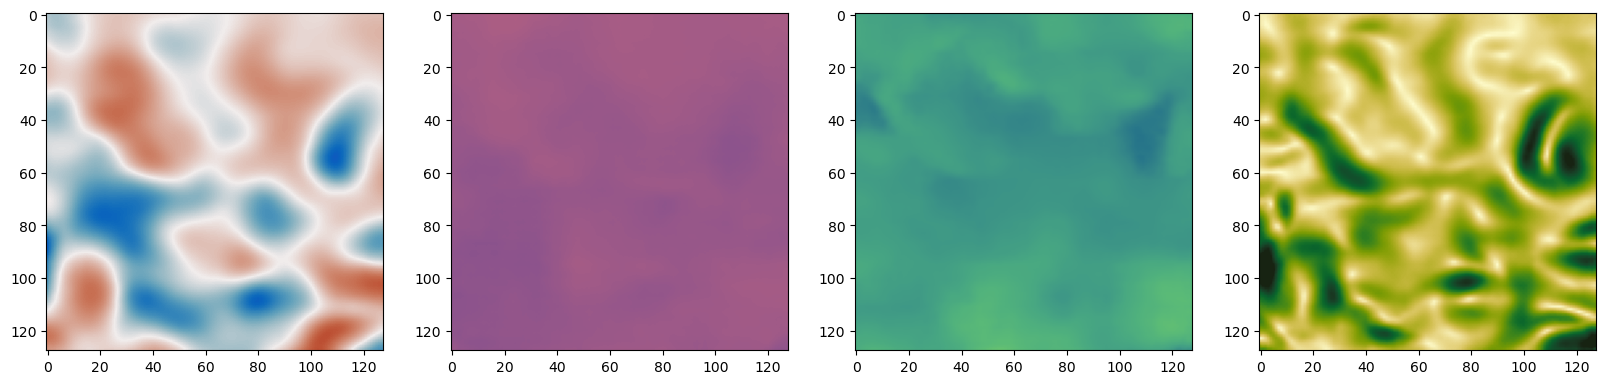

In [16]:
idx = 1

fig, axs = plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(new_content[idx,0,],cmap=cmocean.cm.balance, vmin=-3, vmax = 3)
# axs[0,1].imshow(reconstruction[idx,0,],cmap=cmocean.cm.balance, vmin=-3, vmax = 3)
axs[1].imshow(new_content[idx,1,],cmap=cmocean.cm.thermal, vmin=-3, vmax = 3)
# axs[1,1].imshow(reconstruction[idx,1,],cmap=cmocean.cm.thermal, vmin=-3, vmax = 3)
axs[2].imshow(new_content[idx,2,],cmap=cmocean.cm.haline, vmin=-3, vmax = 3)
# axs[2,1].imshow(reconstruction[idx,2,],cmap=cmocean.cm.haline, vmin=-3, vmax = 3)
axs[3].imshow(np.sqrt(new_content[idx,3,]**2+new_content[idx,4,]**2),cmap=cmocean.cm.speed, vmin=0, vmax = 3)
# axs[3,1].imshow(np.sqrt(reconstruction[idx,3,]**2+reconstruction[idx,4,]**2),cmap=cmocean.cm.speed, vmin=0, vmax = 3)

In [99]:
data_dir = './input_data/'
ds = xr.open_dataset(data_dir + 'cmems_mod_glo_phy_my_0.083deg_P1D-m_multi-vars_70.00W-40.00W_25.00N-45.00N_0.49m_2010-01-01-2020-12-31.nc')
ds_m = xr.open_dataset(data_dir + 'glorys_gulfstream_means.nc')
ds_clim = xr.open_dataset(data_dir + 'glorys_gulfstream_climatology.nc')

var_stds = {'zos':((ds['zos']-ds_m['zos']).std()), 'thetao':((ds['thetao']-ds_clim['thetao']).std()), 'so':((ds['so']-ds_clim['so']).std()), 'uo':((ds['uo']-ds_m['uo']).std()), 'vo':((ds['vo']-ds_m['vo']).std())}

# ngpu = 1




In [120]:
dataset = GAN_dataset(data_dir = './input_data/', latent_dim = 256, n_lon = 128, n_lat = 128, samples_per_day = 20, date_range = [date(2014,1,1),date(2014,12,31)], variables = ['zos', 'thetao', 'so', 'uo', 'vo'], var_stds = var_stds, model_zarr_name = 'glorys_gulfstream_anomaly_zarr', lon_buffers = [3, None], lat_buffers = [None, 2], multiprocessing = True)
batch_size = 64
n_cpus = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = dataset.worker_init_fn,persistent_workers=True)


/nobackupp27/samart18/GenDA/src/dataloaders.py:72: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_lon = self.ds_model.dims['longitude']
/nobackupp27/samart18/GenDA/src/dataloaders.py:73: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_lat = self.ds_model.dims['latitude']
/nobackupp27/samart18/GenDA/src/dataloaders.py:74: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_time = 

In [84]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [121]:
first_batch = next(iter(dataloader))

/nobackupp27/samart18/GenDA/src/dataloaders.py:118: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_lon = self.ds_model.dims['longitude']
/nobackupp27/samart18/GenDA/src/dataloaders.py:119: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_lat = self.ds_model.dims['latitude']
/nobackupp27/samart18/GenDA/src/dataloaders.py:120: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.N_time

In [547]:
device = 'cpu'

In [94]:
vae = vae.to(device)

In [122]:
outvar = vae(first_batch[1].to(device))[0].to('cpu').detach().numpy()

In [123]:
mu, logvar = vae(first_batch[1].to(device))[1].to('cpu').detach().numpy(), vae(first_batch[1].to(device))[2].to('cpu').detach().numpy()

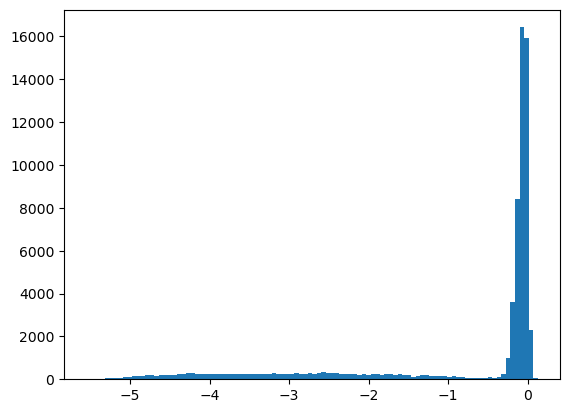

In [124]:
# plt.hist(mu.ravel(),bins = 100);
plt.hist(logvar.ravel(),bins=100);

In [125]:
# outvar = test.detach().numpy()
invar = first_batch[1].detach().numpy()

In [22]:
def kinetic_energy_spectrum_1d(u, v, dx, dy):
    
    fft_u = np.fft.fft2(u)
    fft_u_shifted = np.abs(np.fft.fftshift(fft_u))
    
    fft_v = np.fft.fft2(v)
    fft_v_shifted = np.abs(np.fft.fftshift(fft_v))
    
    fft_magnitude_shifted = 0.5*(fft_u_shifted**2+fft_v_shifted**2)
    
    Nx, Ny = u.shape
    kx = 2 * np.pi * np.fft.fftfreq(Nx, dx)
    ky = 2 * np.pi * np.fft.fftfreq(Ny, dy)
    dk = np.abs(kx[1]-kx[0])
    
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    
    k = np.fft.fftshift(np.sqrt(kx_grid**2 + ky_grid**2))
        
    energy_spectrum = azimuthal_average(fft_magnitude_shifted)
    k_spectrum = azimuthal_average(k)
    energy_spectrum = energy_spectrum*2*np.pi*k_spectrum
    
    return k_spectrum, energy_spectrum
def azimuthal_average(data):
    center = (np.array(data.shape) - 1) / 2.0
    y, x = np.indices(data.shape)
    r_f = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r_f.astype('int')
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

In [141]:
idx = 4
k, psd = kinetic_energy_spectrum_1d(invar[idx,3,],invar[idx,4,],1,1)
k, psd_pred = kinetic_energy_spectrum_1d(outvar[idx,3,],outvar[idx,4,],1,1)
# k, psd_pred2 = kinetic_energy_spectrum_1d(outvar[idx,3,],outvar[idx,4,],1,1)

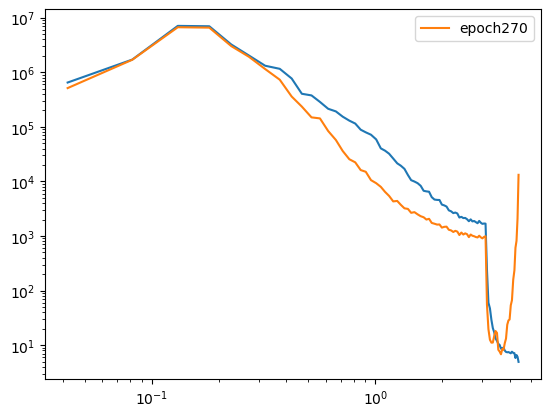

In [142]:
plt.loglog(k,psd)
plt.loglog(k,psd_pred, label = f'epoch{epoch_no}')
# plt.loglog(k,psd_pred2, label = 'epoch10')
plt.legend()

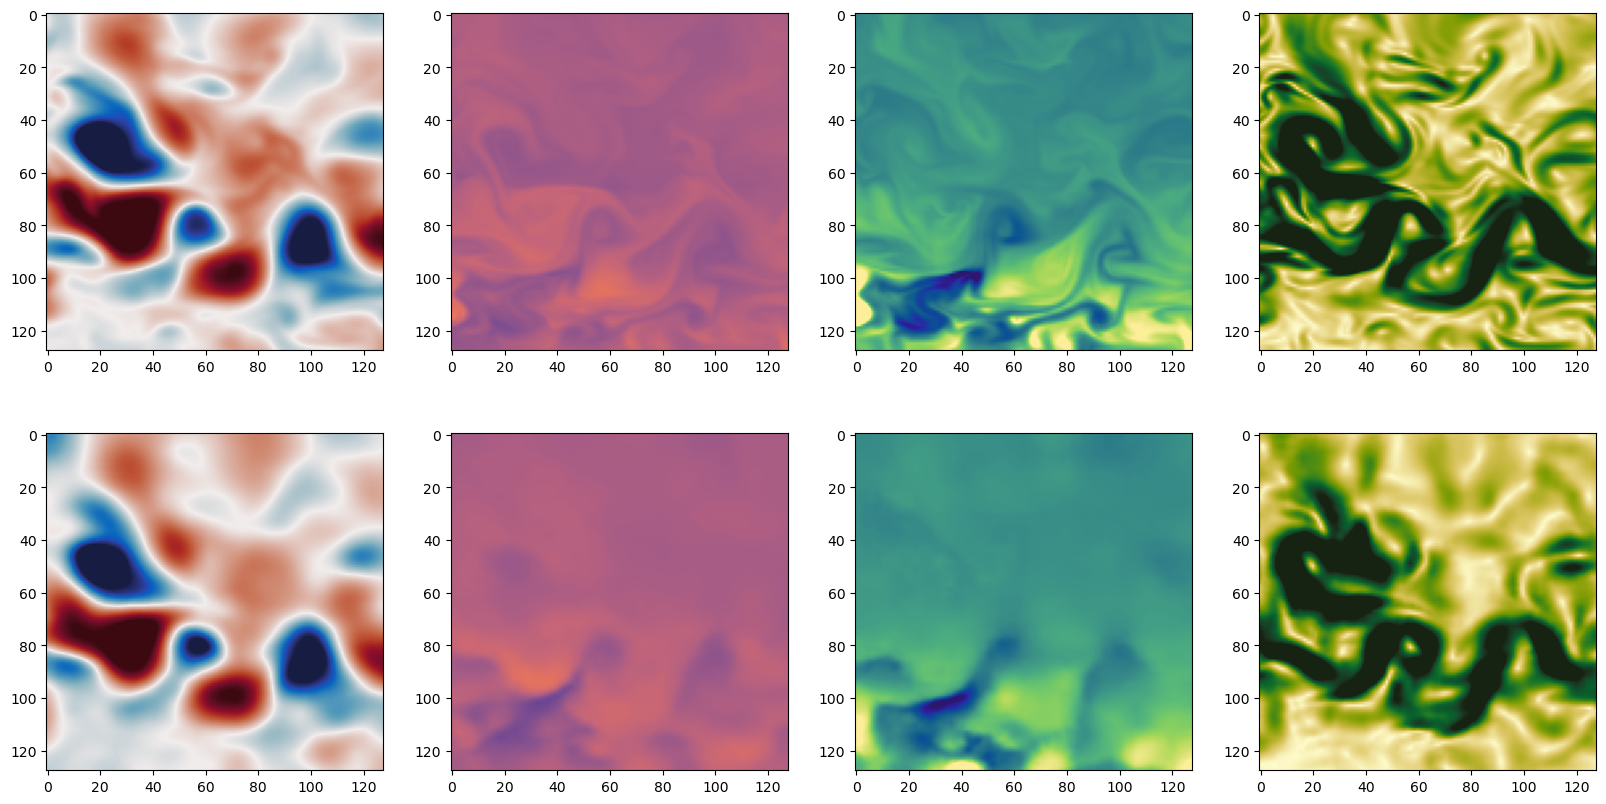

In [143]:
# idx = 4

fig, axs = plt.subplots(2,4,figsize=(20,10))
axs[0,0].imshow(invar[idx,0,],cmap=cmocean.cm.balance, vmin=-3, vmax = 3)
axs[1,0].imshow(outvar[idx,0,],cmap=cmocean.cm.balance, vmin=-3, vmax = 3)
axs[0,1].imshow(invar[idx,1,],cmap=cmocean.cm.thermal, vmin=-3, vmax = 3)
axs[1,1].imshow(outvar[idx,1,],cmap=cmocean.cm.thermal, vmin=-3, vmax = 3)
axs[0,2].imshow(invar[idx,2,],cmap=cmocean.cm.haline, vmin=-3, vmax = 3)
axs[1,2].imshow(outvar[idx,2,],cmap=cmocean.cm.haline, vmin=-3, vmax = 3)
axs[0,3].imshow(np.sqrt(invar[idx,3,]**2+invar[idx,4,]**2),cmap=cmocean.cm.speed, vmin=0, vmax = 3)
axs[1,3].imshow(np.sqrt(outvar[idx,3,]**2+outvar[idx,4,]**2),cmap=cmocean.cm.speed, vmin=0, vmax = 3)

In [41]:
model_parameters = filter(lambda p: p.requires_grad, vae.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [43]:
params/1e6

153.730048

In [144]:
ssh = outvar[idx,0,]
dssh_dx = np.gradient(ssh)[1]
dssh_dy = np.gradient(ssh)[0]
u = outvar[idx,3,]
v = outvar[idx,4,]
du_dx = np.gradient(u)[1]
dv_dx = np.gradient(v)[1]
du_dy = np.gradient(u)[0]
dv_dy = np.gradient(v)[0]


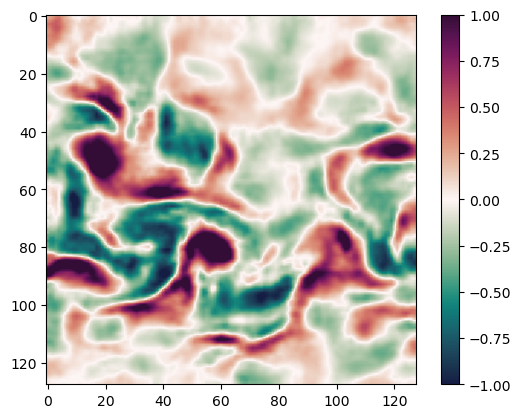

In [145]:
plt.imshow(dv_dx-du_dy, cmap=cmocean.cm.curl, vmin = -1, vmax = 1)
plt.colorbar()

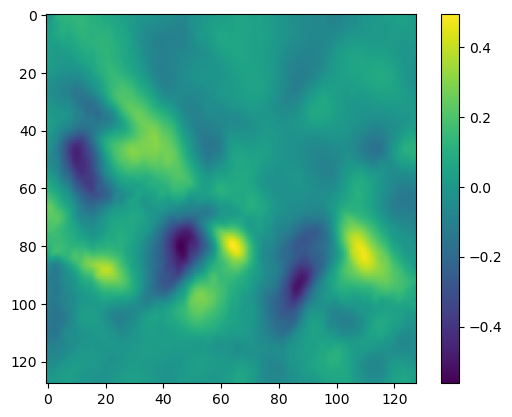

In [146]:
plt.imshow(dssh_dx)
plt.colorbar()

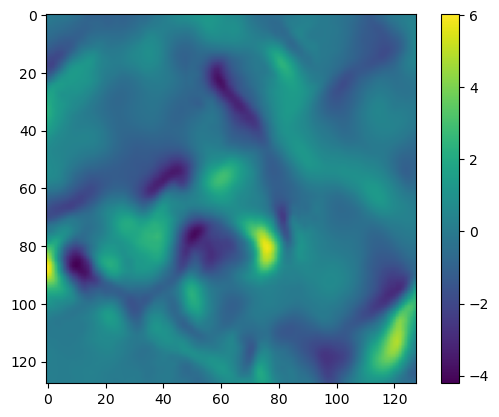

In [506]:
plt.imshow(v)
plt.colorbar()

In [169]:
def J(X, Obs, Mask, z): 
        
    j = ((Obs - X)*Mask*(Obs - X)).mean() 
    z_norm = (z**2).mean()
    
    return j + 0.1*z_norm
    

In [32]:
net = decoder.to('cpu')
# net.eval()
z = torch.randn(2,1024)#.to(device)

z.requires_grad = True
decoder.forward(z).shape

torch.Size([2, 5, 128, 128])

In [82]:
import cma

In [72]:
Mask = torch.zeros(24,5,128,128)#.to(device)
Mask[:,:1,:,:] = 1
truth = first_batch[1][:24,]#.to(device)
Obs = (truth*Mask)#.to(device)

In [83]:
es = cma.CMAEvolutionStrategy(z.detach().numpy().flatten(), 1)

(13_w,26)-aCMA-ES (mu_w=7.6,w_1=23%) in dimension 2048 (seed=420750, Thu Jun 13 12:18:42 2024)


In [85]:
while not es.stop():
    solutions = es.ask()
    losses = []

    for solution in solutions:
        # Set model parameters from solution
        # print(solution[0])
        x = torch.from_numpy(solution.astype('float32'))
        x_shaped = x.reshape(z.shape)
        z.data.copy_(x_shaped) # update z with the new solution
    

        # Calculate loss
        y_pred = net(x_shaped)
        loss = J(y_pred, Obs, Mask,z)#criterion(y_pred, y)
        losses.append(loss.item())
        print(losses[-1])

    # Tell CMA-ES the losses
    es.tell(solutions, losses)  

0.6243056058883667
0.5139117240905762
0.4540401101112366
0.554535984992981
0.5378395915031433
0.5968674421310425
0.4791158139705658
0.4163934588432312
0.7301605939865112
0.6144545674324036
0.546959400177002
0.45465773344039917
0.6089436411857605
0.5201581120491028
0.5539240837097168
0.6087108850479126
0.5331453680992126
0.41427770256996155
0.6381404399871826
0.5824042558670044
0.46877211332321167
0.5998090505599976
0.5000952482223511
0.5860887169837952
0.4896904528141022
0.5013821721076965
0.4562879204750061
0.5146014094352722
0.5420747399330139
0.48372238874435425
0.45457595586776733
0.5494024157524109
0.4930186867713928
0.4582386016845703
0.3924240469932556
0.4192844331264496
0.49342256784439087
0.4838082790374756
0.5004266500473022
0.525040328502655
0.49611610174179077
0.4432221055030823
0.5130316019058228
0.43306976556777954
0.41226035356521606
0.5037817358970642
0.4409257471561432
0.45497483015060425
0.4918975830078125
0.41291481256484985
0.5318560600280762
0.5008841753005981
0.38

KeyboardInterrupt: 

In [33]:
lr=0.01
beta1=0.9
n_epoch= 1000

In [34]:
z.shape

torch.Size([2, 1024])

In [50]:
z[0,]

tensor([ 3.1047e+00, -1.2551e+00,  2.3004e+00, -3.4835e+00,  1.4100e+00,
        -3.7334e+00,  5.6965e-01, -1.1396e+00, -3.0945e+00,  2.7284e+00,
        -2.0709e+00,  2.5334e+00,  1.9524e+00, -3.2960e-01, -1.7568e+00,
         1.2716e+00,  4.9489e-02, -3.2844e+00, -1.9782e+00,  8.5925e-01,
         5.1687e+00,  1.5815e+00, -1.4343e+00, -1.7017e+00,  3.8748e+00,
        -2.7609e+00, -3.1790e+00,  1.0141e+00,  1.6009e+00,  2.6555e+00,
         3.2273e+00,  2.5324e+00, -1.7865e+00, -3.1230e+00, -1.0474e+00,
        -9.7367e-01, -1.0233e+00,  3.3585e+00, -3.4220e+00, -1.7012e+00,
        -1.8739e+00,  1.4978e-01, -1.5701e+00, -4.0469e+00, -1.2873e+00,
         8.0800e-01, -2.4574e+00, -4.4370e+00, -1.5389e+00,  3.9769e-01,
        -3.8428e-01,  2.4138e+00, -2.7693e+00, -2.6544e+00,  1.9148e+00,
         2.7391e+00,  1.1704e+00,  3.5670e-01, -1.8985e+00, -1.4671e+00,
        -2.0666e+00,  4.4401e-01, -1.3073e+00, -2.2146e+00,  2.6718e+00,
        -4.3672e+00, -1.8054e+00, -4.1762e+00, -7.0

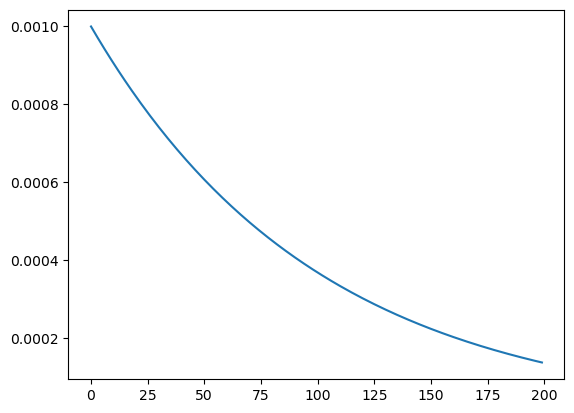

In [148]:
gamma = 0.01
x = np.arange(200)
plt.plot(x, 1e-3*np.exp(-x*gamma))

In [151]:
lr

0.01

In [170]:
from torch.optim.lr_scheduler import ExponentialLR, StepLR

net = decoder.to(device)

Mask = torch.zeros(10,5,128,128).to(device)
Mask[:,:10,:,:] = 1
truth = first_batch[1][:10,].to(device)
Obs = (truth*Mask).to(device)


z = torch.randn(10,1024).to(device)

z.requires_grad = True
optimizer = optim.Adam([z],lr=lr, betas=(beta1, 0.999))
# scheduler = StepLR(optimizer, step_size=20, gamma=0.0001)

losses=[]
rmses_truth=[]
z0 = []
n_epoch = 1000
zs = np.zeros((n_epoch,10,1024))
for i in range(n_epoch):
    zs[i,] = z.to('cpu').detach().numpy()
    net.zero_grad()
    X=net.forward(z)

    loss = J(X, Obs, Mask, z)
    losses.append(loss.item())
    z0.append(z[0,].to('cpu').detach())

    loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_([z], max_norm=1.0) 
    optimizer.step()
    # scheduler.step()
    if i%100 == 0:
        print(i)
        print(loss.item())

0
1.262959361076355
100
0.3834604024887085
200
0.17284312844276428
300
0.17194652557373047
400
0.2335619181394577
500
0.2916720509529114
600
0.3503309488296509
700
0.39323127269744873
800
0.4378458261489868
900
0.46006327867507935


In [59]:
z0[2][0]

tensor(3.4739)

In [56]:
z[0,0]

tensor(3.4739, grad_fn=<SelectBackward0>)

In [42]:
zs = np.zeros((1024,200))
for i in range(224):
    zs[:,i] = np.array(z0[i])

IndexError: list index out of range

In [171]:
norm_z = np.mean(zs**2,axis=(-1,-2))

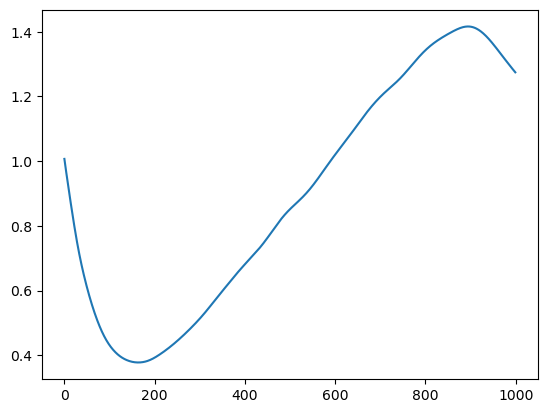

In [172]:
plt.plot(norm_z)

In [189]:
idx = 1

(200, 2, 1024)

In [173]:
idx = 4
preds = np.zeros((n_epoch,5,128,128))
for s in range(n_epoch):
    preds[s,] = decoder(torch.from_numpy(zs[s,idx,:].astype('float32')).to(device)).to('cpu').detach().numpy()[0,]
# pred = decoder(z.to('cpu')).detach().numpy()


In [174]:
unmasked = first_batch[1][:10,].detach().numpy()
unmasked.shape

(10, 5, 128, 128)

In [175]:
errs = preds - unmasked[idx,]

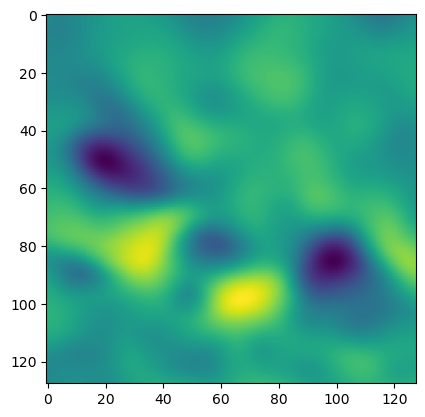

In [176]:
plt.imshow(preds[920,0,])

In [145]:
for t in range(300):
    fig, axs = plt.subplots(2,5,figsize=(12,10))
    axs[0,0].imshow(preds[t,0,], cmap = cmocean.cm.balance, vmin = -3, vmax = 3)
    axs[0,0].set_title('SSH pred (supervised)')
    axs[0,1].imshow(preds[t,1,], cmap = cmocean.cm.thermal, vmin = -3, vmax = 3)
    axs[0,1].set_title('SST pred (supervised)')
    axs[0,2].imshow(preds[t,2,], cmap = cmocean.cm.haline, vmin = -3, vmax = 3)
    axs[0,2].set_title('SSS pred (unsupervised)')
    axs[0,3].imshow(preds[t,3,], cmap = cmocean.cm.balance, vmin = -3, vmax = 3)
    axs[0,3].set_title('U pred (unsupervised)')
    axs[0,4].imshow(preds[t,4,], cmap = cmocean.cm.balance, vmin = -3, vmax = 3)
    axs[0,4].set_title('V pred (unsupervised)')

    axs[1,0].imshow(unmasked[idx,0,], cmap = cmocean.cm.balance, vmin = -3, vmax = 3)
    axs[1,0].set_title('SSH (truth)')
    axs[1,1].imshow(unmasked[idx,1,], cmap = cmocean.cm.thermal, vmin = -3, vmax = 3)
    axs[1,1].set_title('SST (truth)')
    axs[1,2].imshow(unmasked[idx,2,], cmap = cmocean.cm.haline, vmin = -3, vmax = 3)
    axs[1,2].set_title('SSS (truth)')
    axs[1,3].imshow(unmasked[idx,3,], cmap = cmocean.cm.balance, vmin = -3, vmax = 3)
    axs[1,3].set_title('U (truth)')
    axs[1,4].imshow(unmasked[idx,4,], cmap = cmocean.cm.balance, vmin = -3, vmax = 3)
    axs[1,4].set_title('V (truth)')
    
    
    # plt.colorbar()
    fig.suptitle(f'iteration {t}')
    plt.savefig(f'plots/plot{t}.png')
    plt.close('all')

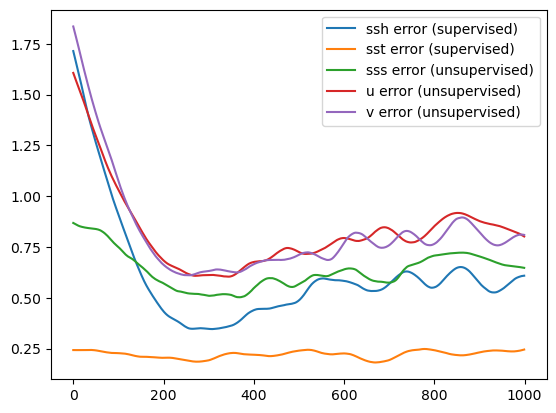

In [186]:
plt.plot(np.sqrt(np.mean(errs[:,0]**2,axis = (-2,-1))), label = 'ssh error (supervised)')
plt.plot(np.sqrt(np.mean(errs[:,1]**2,axis = (-2,-1))), label = 'sst error (supervised)')
plt.plot(np.sqrt(np.mean(errs[:,2]**2,axis = (-2,-1))), label = 'sss error (unsupervised)')
plt.plot(np.sqrt(np.mean(errs[:,3]**2,axis = (-2,-1))), label = 'u error (unsupervised)')
plt.plot(np.sqrt(np.mean(errs[:,4]**2,axis = (-2,-1))), label = 'v error (unsupervised)')
plt.legend()

In [178]:
mu_vae = mu[idx,]
var_vae = np.exp(logvar[idx,])

In [181]:
dim = 12

0.036373958
0.977535


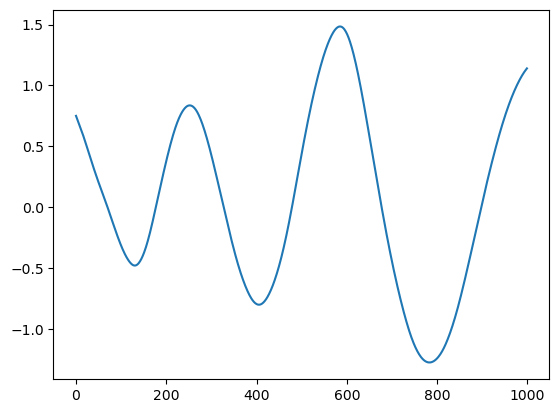

In [182]:
print(mu_vae[dim])
print(var_vae[dim])
plt.plot(zs[:,idx,dim])

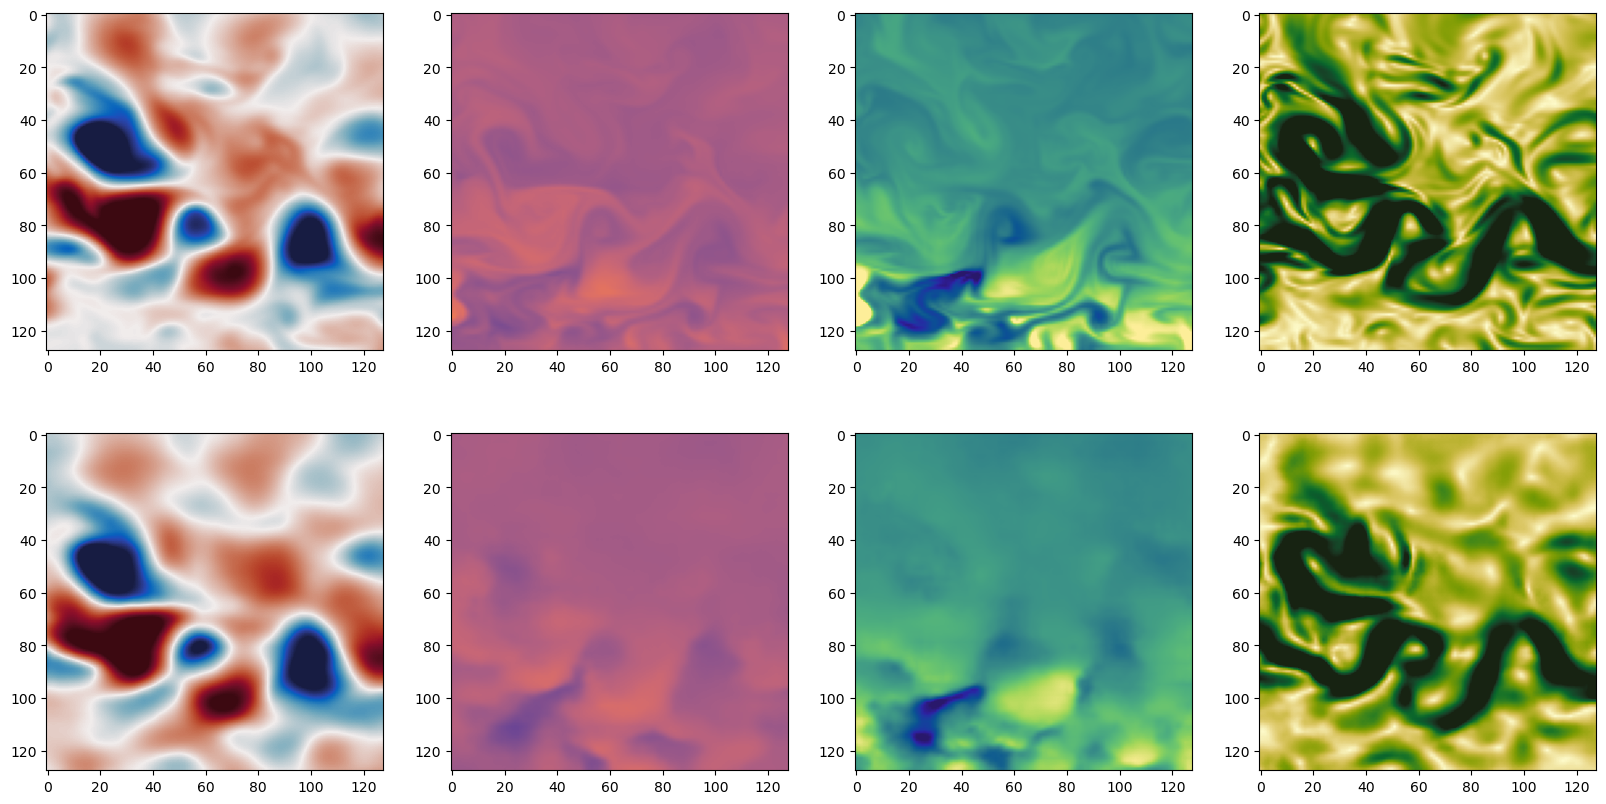

In [185]:
iteration = 250

fig, axs = plt.subplots(2,4,figsize=(20,10))
axs[0,0].imshow(invar[idx,0,],cmap=cmocean.cm.balance, vmin=-3, vmax = 3)
axs[1,0].imshow(preds[iteration,0,],cmap=cmocean.cm.balance, vmin=-3, vmax = 3)
axs[0,1].imshow(invar[idx,1,],cmap=cmocean.cm.thermal, vmin=-3, vmax = 3)
axs[1,1].imshow(preds[iteration,1,],cmap=cmocean.cm.thermal, vmin=-3, vmax = 3)
axs[0,2].imshow(invar[idx,2,],cmap=cmocean.cm.haline, vmin=-3, vmax = 3)
axs[1,2].imshow(preds[iteration,2,],cmap=cmocean.cm.haline, vmin=-3, vmax = 3)
axs[0,3].imshow(np.sqrt(invar[idx,3,]**2+invar[idx,4,]**2),cmap=cmocean.cm.speed, vmin=0, vmax = 3)
axs[1,3].imshow(np.sqrt(preds[iteration,3,]**2+preds[iteration,4,]**2),cmap=cmocean.cm.speed, vmin=0, vmax = 3)

In [97]:
test = torch.abs(torch.fft.fft2(torch.from_numpy(invar)))**2

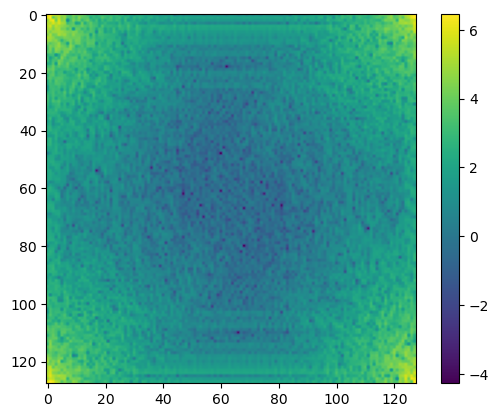

In [100]:
plt.imshow(np.log10(test[0,1,].detach().numpy()))
plt.colorbar()

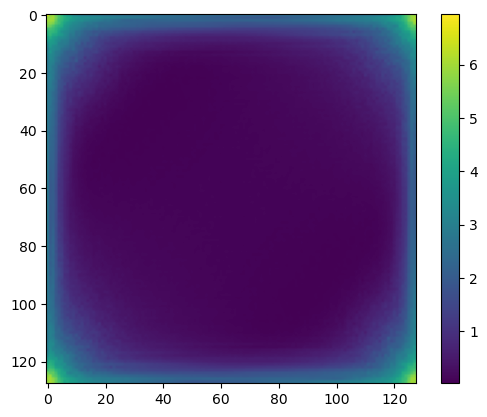

In [101]:
batch = 2
channel = 0
plt.imshow(np.mean(np.log10(1 + np.real(np.fft.fft2(invar)[:,channel,])**2),axis=0))#, cmap = cmocean.cm.b, vmin = -0.0001, vmax = 0.0001)
plt.colorbar()